**EMPEZAMOS CON EL KERNEL ANTERIOR 03-TFM**

En este Kernel, vamos a intentar diseñar nuestros generadores para usar en los modelos, que intentaremos entrenar en los siguientes kernels


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re

['manualdraw', 'carvana-image-masking-challenge']


Using TensorFlow backend.


In [2]:
!mkdir images
#!ls -l '../input/train'

Preparamos unas cuantas funciones para leer del directorio

In [3]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['4b74275babf7_02.jpg', '3071362591f7_04.jpg', '0495dcf27283_10.jpg', 'd1a3af34e674_01.jpg', 'fc237174b128_09.jpg']


[[[0.92156863 0.92156863 0.92156863]
  [0.92156863 0.92156863 0.92156863]
  [0.92156863 0.92156863 0.92156863]
  ...
  [0.92941176 0.92941176 0.92941176]
  [0.92941176 0.92941176 0.92941176]
  [0.92941176 0.92941176 0.92941176]]

 [[0.92156863 0.92156863 0.92156863]
  [0.92156863 0.92156863 0.92156863]
  [0.92156863 0.92156863 0.92156863]
  ...
  [0.92941176 0.92941176 0.92941176]
  [0.92941176 0.92941176 0.92941176]
  [0.92941176 0.92941176 0.92941176]]

 [[0.92156863 0.92156863 0.92156863]
  [0.92156863 0.92156863 0.92156863]
  [0.92156863 0.92156863 0.92156863]
  ...
  [0.92941176 0.92941176 0.92941176]
  [0.92941176 0.92941176 0.92941176]
  [0.92941176 0.92941176 0.92941176]]

 ...

 [[0.75686275 0.77254902 0.78431373]
  [0.75686275 0.77254902 0.78431373]
  [0.75686275 0.77254902 0.78431373]
  ...
  [0.80784314 0.73333333 0.74117647]
  [0.80392157 0.72941176 0.7372549 ]
  [0.8        0.7254902  0.73333333]]

 [[0.75686275 0.77254902 0.78431373]
  [0.75686275 0.77254902 0.78431373]


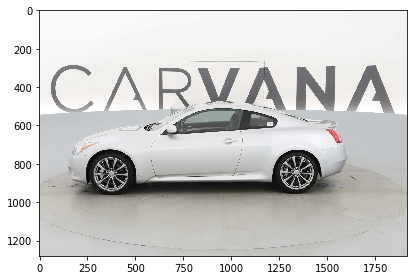

In [4]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [5]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [6]:
len(mask)

5088

In [7]:
# ignore this function not needed finally... reference https://www.kaggle.com/robertkag/rle-to-mask-converter finally not used but i like this function i saved..

import numpy as np # linear algebra
#(1280, 1918, 3)

def rleToMask(rleString,height,width):
    rows, cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [8]:
#index=3
#temp_mask = rleToMask(mask['rle_mask'][3],WIDTH,HEIGH)
#print(temp_mask.shape)
#rotated_mask = np.rot90(np.rot90(np.rot90(temp_mask)))
#imshow(rotated_mask)


In [9]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)

# get first masked value (foreground)
fg = cv2.bitwise_or(img, img, mask=mask)
# get second masked value (background) mask must be inverted
mask = cv2.bitwise_not(mask)
background = np.full(img.shape, 255, dtype=np.uint8)
bk = cv2.bitwise_or(background, background, mask=mask)

# combine foreground+background
final = cv2.bitwise_or(fg, bk)

../input/carvana-image-masking-challenge/train/fff9b3a5373f_12.jpg
../input/carvana-image-masking-challenge/train_masks/fff9b3a5373f_12_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Bien hay que tener presente el objetivo, el objetivo final es usar la liberia OpenCv, en concreto el alghotirmo de CanyEdge detection, que nos permite resaltar y extraer contornos de una imagen, esta imagen va a suer nuestros inputs en las GAN, es decir seremos capaz de reconstruir un coche solamente conociendo su contorno?
Para ellos i conociendo a priori el Canny Edge detection, va a funcionar mejor si somos capaces de extraer de la imagen completa unicamente los elementos que nos interesan, es decir solo el coche

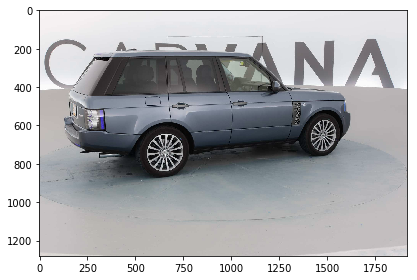

In [10]:
#La imagen original
imshow(img)

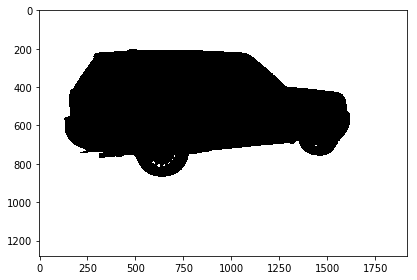

In [11]:
#La mascara
imshow(mask)

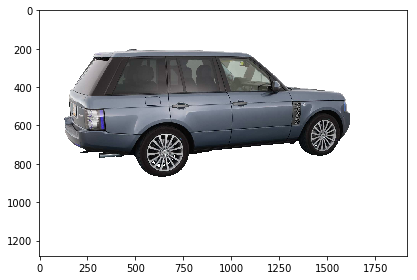

In [12]:
#La imagen del coche aplicando la mascara
# BIEN!!! ahora vamos a intentar extraer los contornos!!
imshow(final)

# Empezamos con un ejemplo basico de la pagina de OpenCV

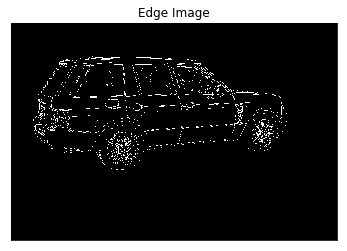

In [13]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final
edges = cv2.Canny(img,50,100)

#plt.subplot(121),
plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#plt.subplot(122),
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()
#La aproximación no es muy buena necessitamos las lineas del contorno

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


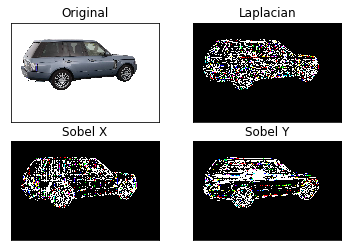

In [14]:
# Usamos otro ejemplo de la pagina OpenCV
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = final

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

Estabamos por buen camino, antes de applicar el cannyedge detection tal como explica en la doc de OpenCV, antes se debia de corregir las imagenes aplicando GaussianBlur i erode para cerrar gaps
Adjunto fuentes de información
#https://stackoverflow.com/questions/21104664/extract-all-bounding-boxes-using-opencv-python/21108680
#https://stackoverflow.com/questions/13887863/extract-bounding-box-and-save-it-as-an-image
#https://www.kaggle.com/ayalamann/bounding-boxes-using-image-processing
#https://cvisiondemy.com/extract-roi-from-image-with-python-and-opencv/

(1280, 1918)


255

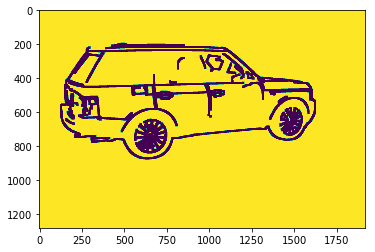

In [15]:
def get_edge_v2(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((3,3), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 3)
    #plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    #return np.invert(canny_edges)#return np.invert(canny_edges)
    #plt.imshow(canny_edges)

    #close the small line gaps using dilation
    kernel = np.ones((5,5), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 3)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    #invetimos la mascara queremos el blanco de fondo y el negro como dibujo del coche
    return np.invert(canny_blurred)
ret =get_edge_v2(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)


Es Fantastico!!! con esto podemos seguir adelante con el TFM!!! Nos preparamos una función get edges random que usaremos en los data augmentation!

In [16]:
def get_edge_v2_randoms(img):
    choise=[3,5,7]
    x = np.random.choice(choise,1)
    
    blurred = cv2.GaussianBlur(img, (x,x), 0) # Remove noise
    #close the small line gaps using errosion
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    erode = cv2.erode(blurred, kernel, iterations = x)
    # plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    x = np.random.randint(80,125)
    y = np.random.randint(135,180)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=100, threshold2=150) 
    #return np.invert(canny_edges)
    # plt.imshow(canny_edges)

    #close the small line gaps using dilation
    x = np.random.randint(2,5)
    kernel = np.ones((x,x), np.uint8)
    x = np.random.randint(2,5)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = x)
    
    x = np.random.choice(choise,1)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (x,x), 0) # Remove noise
    return np.invert(canny_blurred)


(1280, 1918)


255

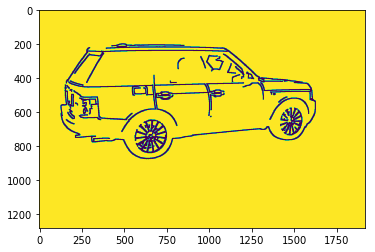

In [17]:
ret =get_edge_v2_randoms(final)
plt.imshow(ret)
print(ret.shape)
np.max(ret)

AxesImage(38.5601,27.8;382.64x245.485)


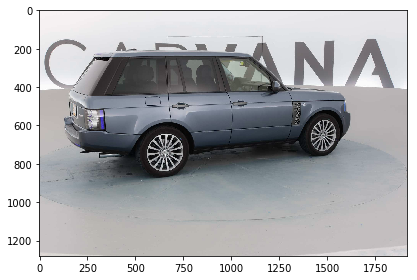

In [19]:
print(imshow(cv2.imread(carimage)))

In [20]:
from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(input_files, input_files, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))

4324
764


Para augmentar las imagenes, vamos a usar la liberia conocida "imgaug", en siguiente kernels intentaremos desarrollar nuestros porpios augmentadores, trabajando con la numpy directamente.. pero esta liberia nos permite hacer una augmentación de manera muy rapida

In [21]:
from imgaug import augmenters as iaa
import imgaug as ia
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    # iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
    sometimes(iaa.Affine(
            scale={"x": (1, 1.2), "y": (1, 1.2)}, # scale images to 80-120% of their size, individually per axis
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            #rotate=(-45, 45), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
])

Preparamos nuestra funciones de utilidad para nuestro augmentador

In [23]:
import skimage
BATCH_SIZE=32

def get_clean_image(path,path_mask):    
    img = cv2.imread(path)
    # img = cv2.resize(img, (h, w))
    # print(imshow(img))
    #mask = cv2.imread(maskimage)
    mask=np.int8((imread(path_mask)))
    # print(mask)   
    # get first masked value (foreground)
    fg = cv2.bitwise_or(img, img, mask=mask)
    # get second masked value (background) mask must be inverted
    mask = cv2.bitwise_not(mask)
    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv2.bitwise_or(background, background, mask=mask)

    # combine foreground+background
    final = cv2.bitwise_or(fg, bk)

    return final

def generator_int(path, batch_size=BATCH_SIZE, normalize=True, augmented=True):
    
    #retedge = np.zeros((batch_size,H,W,3),dtype=np.int16)
    #retimg = np.zeros((batch_size,H,W,3),dtype=np.int16)
    retedge = []
    retimg = []
    imgorig=[]
    for x in range(batch_size):
        car = np.random.choice(path,1)[0]
        carpath = car_path+car
        maskpath = mask_path+car.replace('.jpg','_mask.gif')
        #print(maskpath)
        img =  get_clean_image(carpath, maskpath)
        retimg.append(img)
        #mask = get_edge_v2(retimg[x])
        #mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        #retedge.append(mask)
 #       retimg[x] = img
        #imgorig = img
        # print(retimg[x].shape)
        #print(np.max(retimg[x]))
        #mask = get_edge_v2(img)
        
        # mask = skimage.color.gray2rgb(mask.reshape(H,W,1))
        #print(mask.shape)
        #retedge[x] = mask
    #augmented images
    if augmented:
        retimg = seq.augment_images(np.array(retimg))
    else:
        retimg = np.array(retimg)
    #for x in range(batch_size):
#        imgorig.append(retimg[x])
    #
    for x in range(batch_size):
        #print(x)
        mask = get_edge_v2(retimg[x])
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        retedge.append(mask)
        
    
    #if normalize:
#        retimg = retimg/255
       # retedge = retedge/255
    return np.array(retedge), np.array(retimg)

In [24]:
indx=500
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')
# img = get_clean_image(carimage, maskimage)
A,B = generator_int(train_input,1,False)
B.shape

(1, 1280, 1918, 3)

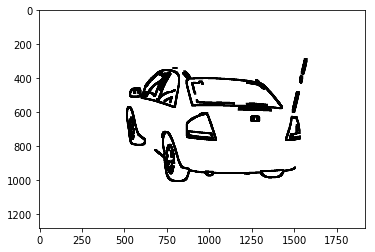

In [25]:
plt.imshow(A[0])


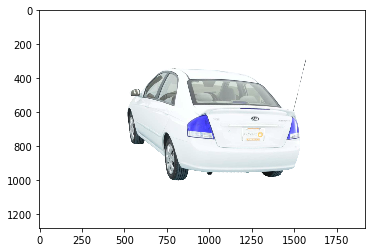

In [26]:
plt.imshow(B[0])

In [27]:
def downsample(img, h, w):    
    # ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return cv2.resize(img, (h, w))

def generator_resize(path="", batch_size=BATCH_SIZE, normalize=True, h=256, w=256, augmented=True):
    a,b = generator_int(path,batch_size,False, augmented)
    
    #resize image
    newA=[]
    newB=[]
    for x in range(batch_size):
        newA.append(downsample(a[x],h,w))
        newB.append(downsample(b[x],h,w))

    return np.array(newA), np.array(newB)

In [28]:
H = 256
W = 256
A, B = generator_resize(train_input,1, False, H,W)
A.shape

(1, 256, 256, 3)

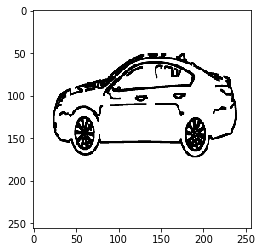

In [29]:
plt.imshow(A[0])

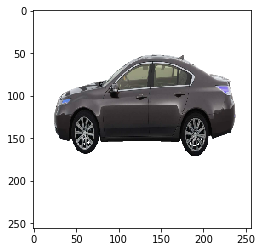

In [30]:
plt.imshow(B[0])

In [31]:
#Conseguido, tenemos un generador que aplica augmentacion a las imagenes y a las mascaras